In [10]:
# import needed libraries
import requests  # to handle http requests
from bs4 import BeautifulSoup  # to handle html codes
from fake_useragent import UserAgent # to create fake user agents 
import pandas as pd # 
import time # used as sleep(seconds)
from selenium import webdriver # to read
from selenium.webdriver.common.by import By # to enable selection of HTML elements by specific CSS selectors
from selenium.webdriver.chrome.options import Options # to enable change of user agent 


The following class diagram shows the scholar scrapper class with its functions. 

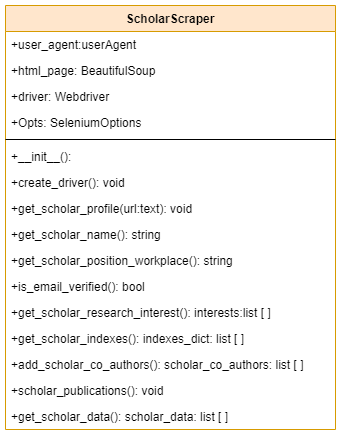

In [11]:
class ScholarScrapper():

    # Declare used variables.
    def __init__(self):
        self.user_agent = None
        self.html_page = None # initially empty then will hold the scholar html page
        self.driver = None
        # options for the web driver 
        self.opts = Options()
        self.opts.add_argument("--headless")

    def create_driver(self):
        self.opts.add_argument(f"--user-agent={self.user_agent}")
        self.driver = webdriver.Chrome(options=self.opts)

    # Obtain the scholar HTML page   
    def get_scholar_profile(self, url):

        # Create driver with different usergent
        self.create_driver()
        # Getting the web page
        self.driver.get(url)
        # showing all the publications via click "show More"
        element = self.driver.find_element(By.ID, 'gsc_bpf_more')
        while element.is_enabled(): # button is clickable
            element.click()
            time.sleep(0.5)

        # convert it to an html for beautiful soup parsing
        response = self.driver.page_source
        # Convert the html string to a BeautifulSoup Object
        self.html_page = BeautifulSoup(response, 'html.parser')

    # Obtain the name
    def get_scholar_name(self):
        # obtain the name
        name =  self.html_page.find('div', {'id':'gsc_prf_in'})
        return str(name.text) if name.text else None # return the name else None
    
    # Obtain the working place and position
    def get_scholar_position_workplace(self):
        works_in =  self.html_page.find('div', {'class':'gsc_prf_il'})
        # returns the position and work place
        return works_in.text
    
    # Is emial is verified or not?
    def is_email_verified(self):
        # email verified or not, we will store it as boolean
        email =  self.html_page.find('div',{'id':'gsc_prf_ivh'})
        # convert the email to boolean
        return True if 'Verified' in email.text else False
    
    # Obtain the research interests
    def get_scholar_research_interests(self):
        research_interests =  self.html_page.find_all('a',{'class':'gsc_prf_inta'})
        # loop over the research interests to convert them into a list
        interests = []
        for interest in research_interests:
            interests.append( str(interest.text) )

        return interests
    
    # Obtain citations, h-index, and i10th-index
    def get_scholar_indexes(self):
        try:
            # finding citation and indexes
            cit_ind_tab =  self.html_page.find ('table', {'id':'gsc_rsb_st'})
            # obtain all the table rows which contains the indexes 
            indexes_table = cit_ind_tab.find_all('tr')
            indexes_table.pop(0) # remove the first row which is the header, 

            indexes_dict = [] # [citation, h-index, i10th-index]

            for index in indexes_table:
                # for each index obtain the name and value
                # index_name = str( index.find('a',{'class':'gsc_rsb_f'}).text)
                index_val = int(index.find('td', {'class':'gsc_rsb_std'}).text)
                # store the name and value pairs in a dictionary
                indexes_dict.append(index_val)
            
            return indexes_dict
        except:
            return None
        
    # Add scholar co-authors to overall scholar links
    def add_scholar_co_authors(self, scholars_urls):
        ''' This function crawls to expand the networks to other scholars'''
        # obtain all the links of the contributoring authors
        co_auth_spans = self.html_page.find_all('span',{'class':'gsc_rsb_a_desc'})
        scholar_co_authors = []
        # obtain the links for these co authors
        for co_auth in co_auth_spans:
            # verify that the link is not already added in the overall links for all the scholars
            if co_auth.a['href'] not in scholars_urls:
                scholars_urls.append(co_auth.a['href'][co_auth.a['href'].find("user=")+5:co_auth.a['href'].find("user=")+17])   # store the link

            scholar_co_authors.append(co_auth.a['href'][co_auth.a['href'].find("user=")+5:co_auth.a['href'].find("user=")+17] )

        return scholar_co_authors
    
    def scholar_publications(self, shcolar_id, publications):
        researches =self.html_page.find_all("tr", {'class':'gsc_a_tr'} )
        
        # store data in ["title", "citation_#", "Year", "authorsList", "Journal", "Auth_id"]
        for research in researches:
            publication = []
            # getting the title
            publication.append(research.td.a.text)
            # adding the citations
            publication.append(research.find("td","gsc_a_c").a.text)

            # add the year
            publication.append(research.find("td","gsc_a_y").span.text)
          
            # adding the authorsList
            publication.append(research.td.div.text )
            # adding the Journal
            publication.append(research.td.find_all("div", "gs_gray")[1].text)
            # adding the author_id
            publication.append(shcolar_id)
            
            publications.append(publication)
            
    # Obtain the scholar data
    def get_scholar_data(self, user_agent, url, scholars_links, publicatons):
        """function to collect scholar data as a list 
           returns:
             [name, position_university, emailVerification, research_interest_list, citation, h-index, i10th-index, url, co_authors]
         """
        # first prepare user data
        self.user_agent = user_agent # assign a user-agent
        self.get_scholar_profile(url)

            
        scholar_data = []
        # add name
        scholar_data.append( self.get_scholar_name() )
        # add position and university
        scholar_data.append(self.get_scholar_position_workplace() )
        
        # add email_verified True or False
        scholar_data.append( self.is_email_verified() )
        # add research interests
        scholar_data.append( self.get_scholar_research_interests() )
        # citation indexes
        scholar_data.extend( self.get_scholar_indexes() )
        # scholar link 
        scholar_id = url[url.find("user=")+5: url.find("user=")+17]
        scholar_data.append(scholar_id)
        # add co-authors 
        scholar_data.append( self.add_scholar_co_authors(scholars_links) )

        # getting the scholar publications
        self.scholar_publications(scholar_id, publicatons)

        # return the scholar data list
        return scholar_data
    



The following table shows the Google Scholar Scraper and its functions.

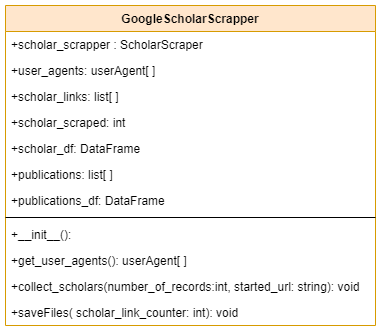

In [12]:
class GoogleScholarScraper():

    def __init__(self):
        self.scholar_scraper = ScholarScrapper( )
        self.user_agents = self.get_user_agents()
        self.scholars_links = ['0zjyTYoAAAAJ', 'jXuvXP0AAAAJ']  #["/citations?hl=en&user=jXuvXP0AAAAJ"] # add to link https://scholar.google.com
        self.scholars_scraped = 0
        # dataframe for the authors
        self.scholars_df = pd.DataFrame(columns = ["name", "position & university", "emailVerification",
                                                 "research_interest_list", "citation", "h-index", 
                                                " i10th-index", "ID", "co_authors"])
        # dataframe for the author publications
        self.publications = []
        self.publications_df = None # to hold publications in a dataframe format
    
    # Obtain a random user agent (10 user agents)
    def get_user_agents(self):
        ua = UserAgent()
        return [ ua.random for i in range(10)]

    # Collect the data
    def collect_scholars(self, number_of_records, starter_url):
        self.scholars_links.append( starter_url ) 
        # loop for 10K scholar links
        counter = 0 # to reset the user agents after each 4 calls
        scholar_link_counter = 0
        while ( (self.scholars_scraped   < number_of_records) & (self.scholars_scraped != len(self.scholars_links)) ):
            print("Collecting...")
            try:
                counter += 1
                if counter == 4: # after using same user agents 4 times, replace them
                    self.get_user_agents() # replace user agents

                # call to collect the data of these 10s 
                for user in self.user_agents:
                    if ( (self.scholars_scraped   < number_of_records) & (scholar_link_counter >= len( self.scholars_links )) ):
                        break # if there are no more links to navigate

                    # obtain the scholar url 
                    url = "https://scholar.google.com/citations?hl=en&user=" + self.scholars_links[ scholar_link_counter]
                    self.scholars_scraped += 1
                    scholar_link_counter +=1
                    # Getting data and adding it to the dataframe
                    self.scholars_df.loc[len(self.scholars_df)] = self.scholar_scraper.get_scholar_data(user, url , self.scholars_links, self.publications)

                # time to wait (5) before looping again
                time.sleep(5)
                
            except Exception as e:
                print("Exception:", type(e))  # Print the type of exception
                if "captcha" in str(e).lower():  # Check for keywords indicating a captcha
                    print("Captcha encountered!")
                else:
                    print("Other error:", e)

                # Additional potential checks for specific errors (adjust as needed):
                if isinstance(e, requests.exceptions.Timeout):
                    print("Timeout error: request timed out.")

                print(url) # the url at which the error happened
        
        # converting the publications into a dataframe
        self.publications_df = pd.DataFrame( self.publications, columns = ["title", "citation_#", "Year",
                                                 "authorsList", "Journal", "Auth_id" ] )
        self.saveFiles(scholar_link_counter)


    def saveFiles(self, scholar_link_counter):
        print("Saving Scholars Dataset File....")
        self.scholars_df.to_csv(f"datasets\\ScholarsDataset_{scholar_link_counter}.csv") # store the infor to a dataframe
        print(f"Successfully save file 'ScholarsDataset_{scholar_link_counter}.csv' ")

        # storing the publications dataset
        print("Saving Publications Dataset File....")
        self.publications_df.to_csv(f"datasets\\publications_dataset.csv") # storing the publicaton dataset
        print(f"Successfully save file 'publications_dataset.csv' ")



In [13]:
test = GoogleScholarScraper()
test.collect_scholars( number_of_records = 10000, starter_url= 'DhtAFkwAAAAJ')

Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Collecting...
Except